In [1]:
import pandas as pd
import torch
import seaborn
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error

## Manual data changes

In [2]:
data = pd.read_csv('../generated_csvs/final_data_draft.csv')

# Sorting the data by season and gameweek
data_sorted = data.sort_values(by=['season', 'gameweek'])

# Drop columns that are not present in the test phase
## i.e drop columns that will be NaN in future gameweeks
drop_cols = ['assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
       'goals_scored', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'saves', 'selected', 'transfers_balance', 'transfers_in',
       'transfers_out', 'yellow_cards', 'score', 'opponent_score',
       'difficulty_category', 'Unnamed: 0', 'Unnamed: 0.1', 'team_a_score', 'team_h_score']
data_sorted.drop(columns=drop_cols, inplace=True)

data_sorted.columns

Index(['name', 'position', 'team', 'creativity', 'element', 'fixture',
       'ict_index', 'influence', 'minutes', 'opponent_team', 'round', 'threat',
       'total_points', 'value', 'was_home', 'gameweek', 'season',
       'opponent_team_name', 'difficulty', 'opponent_difficulty',
       'form_last_3', 'avg_points_against_difficulty'],
      dtype='object')

In [3]:

data_sorted = pd.get_dummies(data_sorted, columns=['position'])

#data_sorted = data_sorted.drop(['opponent_difficulty_category'], axis=1)
last_gameweek = data_sorted.where(data_sorted['season'] == '2023-24')['gameweek'].max()

train_data = data_sorted[~((data_sorted['season'] == '2023-24') & (data_sorted['gameweek'] == last_gameweek))]
test_data = data_sorted[(data_sorted['season'] == '2023-24') & (data_sorted['gameweek'] == last_gameweek)]
val_data = train_data[train_data['season'] == '2023-24']
train_data = train_data[train_data['season'] != '2023-24']

X_train = train_data.drop(columns=['total_points'])
y_train = train_data['total_points']

X_val = val_data.drop(columns=['total_points'])
y_val = val_data['total_points']

X_test = test_data.drop(columns=['total_points'])
y_test = test_data['total_points']


X_train.shape, X_val.shape, X_test.shape, last_gameweek

((92901, 24), (2641, 24), (703, 24), 5.0)

In [4]:
X_train['season'].unique(), X_val['season'].unique(), X_val['gameweek'].unique(), X_test['gameweek'].unique()

(array(['2019-20', '2020-21', '2021-22', '2022-23'], dtype=object),
 array(['2023-24'], dtype=object),
 array([1., 2., 3., 4.]),
 array([5.]))

In [5]:
nan_columns_test = X_test.isna().sum()
nan_columns_test = nan_columns_test[nan_columns_test > 0]
print(nan_columns_test)

# Remove all rows from X_test that have 0 in avg_points_against_difficulty, suggesting player hasn't played yet
X_test.dropna(subset=['avg_points_against_difficulty'], inplace=True)

nan_columns_test = X_test.isna().sum()
nan_columns_test = nan_columns_test[nan_columns_test > 0]
print(nan_columns_test)


avg_points_against_difficulty    61
dtype: int64
Series([], dtype: int64)


In [6]:
nan_columns_train = X_train.isna().sum()
nan_columns_train = nan_columns_train[nan_columns_train > 0]
print(nan_columns_train)

# X_train['team_a_score'].fillna(X_train['team_a_score'].median(), inplace=True)
# X_train['team_h_score'].fillna(X_train['team_h_score'].median(), inplace=True)
# X_val['team_a_score'].fillna(X_val['team_a_score'].median(), inplace=True)
# X_val['team_h_score'].fillna(X_val['team_h_score'].median(), inplace=True)
X_train['form_last_3'].fillna(0,  inplace=True)
X_val['form_last_3'].fillna(0, inplace=True)

# Confirming that NaN values have been addressed
nan_columns_check = X_train.isna().sum()
nan_columns_check = nan_columns_check[nan_columns_check > 0]

nan_columns_check

form_last_3    1330
dtype: int64


Series([], dtype: int64)

## Testing functions

In [2]:
import sys
sys.path.append('../')

import feature_utils as feat_util
import fetch_data as data_getter
import clean_data as cleaner
import pandas as pd

In [3]:
# Test data getters
pdd = data_getter.get_all_player_data()
future = data_getter.get_future_gameweeks(pdd)
all_df = pd.concat([pdd, future])

pdd.shape, future.shape, all_df.shape, all_df.columns

Gameweek 9 for season 2023-24 hasn't been played yet.


((104482, 42),
 (725, 42),
 (105207, 42),
 Index(['name', 'position', 'team', 'assists', 'bonus', 'bps', 'clean_sheets',
        'creativity', 'element', 'fixture', 'goals_conceded', 'goals_scored',
        'ict_index', 'influence', 'minutes', 'opponent_team', 'own_goals',
        'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves',
        'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points',
        'transfers_balance', 'transfers_in', 'transfers_out', 'value',
        'was_home', 'yellow_cards', 'season', 'gameweek', 'starts',
        'kickoff_time', 'difficulty', 'opponent_difficulty', 'score',
        'opponent_score', 'opponent_team_name'],
       dtype='object'))

In [4]:
future

,name,position,team,assists,bonus,bps,clean_sheets,creativity,element,fixture,...,season,gameweek,starts,score,opponent_score,kickoff_time,difficulty,opponent_difficulty,opponent_team,opponent_team_name
0,Femi Seriki,DEF,Sheffield Utd,NaN,NaN,NaN,NaN,0.0,653,89,...,2023-24,9.0,0.0,NaN,NaN,2023-10-21 19:00:00+00:00,3,2,14,Man Utd
1,Josh Brooking,DEF,Chelsea,NaN,NaN,NaN,NaN,0.0,723,84,...,2023-24,9.0,0.0,NaN,NaN,2023-10-21 16:30:00+00:00,4,3,1,Arsenal
2,Radek Vítek,GK,Man Utd,NaN,NaN,NaN,NaN,0.0,669,89,...,2023-24,9.0,0.0,NaN,NaN,2023-10-21 19:00:00+00:00,2,3,17,Sheffield Utd
3,Jack Hinshelwood,MID,Brighton,NaN,NaN,NaN,NaN,0.0,621,86,...,2023-24,9.0,0.0,NaN,NaN,2023-10-21 14:00:00+00:00,5,3,13,Man City
4,Jadon Sancho,MID,Man Utd,NaN,NaN,NaN,NaN,0.0,397,89,...,2023-24,9.0,0.0,NaN,NaN,2023-10-21 19:00:00+00:00,2,3,17,Sheffield Utd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,Kyle Walker,DEF,Man City,NaN,NaN,NaN,NaN,6.1,369,86,...,2023-24,9.0,1.0,NaN,NaN,2023-10-21 14:00:00+00:00,3,5,5,Brighton
721,Jacob Brown,FWD,Luton,NaN,NaN,NaN,NaN,0.8,631,88,...,2023-24,9.0,1.0,NaN,NaN,2023-10-21 14:00:00+00:00,2,2,16,Nott'm Forest
722,Vicente Guaita,GK,Crystal Palace,NaN,NaN,NaN,NaN,0.0,227,87,...,2023-24,9.0,0.0,NaN,NaN,2023-10-21 14:00:00+00:00,4,2,15,Newcastle
723,Braian Ojeda Rodríguez,MID,Nott'm Forest,NaN,NaN,NaN,NaN,0.0,459,88,...,2023-24,9.0,0.0,NaN,NaN,2023-10-21 14:00:00+00:00,2,2,12,Luton


In [5]:
all_df['kickoff_time']

0     2021-08-14 11:30:00+00:00
1     2021-08-14 14:00:00+00:00
2     2021-08-14 14:00:00+00:00
3     2021-08-14 14:00:00+00:00
4     2021-08-14 11:30:00+00:00
                 ...           
720   2023-10-21 14:00:00+00:00
721   2023-10-21 14:00:00+00:00
722   2023-10-21 14:00:00+00:00
723   2023-10-21 14:00:00+00:00
724   2023-10-21 14:00:00+00:00
Name: kickoff_time, Length: 105207, dtype: datetime64[ns, UTC]

In [6]:
nan_counts = all_df.isna().sum()
nan_counts = nan_counts[nan_counts > 0]
print(nan_counts)

position               22560
team                   22560
assists                  725
bonus                    725
bps                      725
clean_sheets             725
goals_conceded           725
goals_scored             725
own_goals                725
penalties_missed         725
penalties_saved          725
red_cards                725
saves                    725
selected                 725
team_a_score              59
team_h_score              59
total_points             725
transfers_balance        725
transfers_in             725
transfers_out            725
yellow_cards             725
starts                 72372
kickoff_time           22560
difficulty             22560
opponent_difficulty    22560
score                  23285
opponent_score         23285
dtype: int64


In [7]:
# Test data cleaners
cleaned_df = cleaner.clean_player_data(all_df, data_getter.get_all_fixture_df())
nan_counts = cleaned_df.isna().sum()
nan_counts = nan_counts[nan_counts > 0]
print(nan_counts)

assists                725
bonus                  725
bps                    725
clean_sheets           725
goals_conceded         725
goals_scored           725
own_goals              725
penalties_missed       725
penalties_saved        725
red_cards              725
saves                  725
selected               725
total_points           725
transfers_balance      725
transfers_in           725
transfers_out          725
yellow_cards           725
starts               49812
score                  725
opponent_score         725
dtype: int64


In [7]:
cleaned_df['position'].unique()

array(['DEF', 'GK', 'MID', 'FWD'], dtype=object)

In [9]:
# Test feature generation
player_df = cleaned_df
player_df = feat_util.generate_difficulty_feature(player_df)
player_df = feat_util.encode_positions(player_df)
player_df = feat_util.generate_rolling_form(player_df)
player_df = feat_util.get_rolling_avg_mins(player_df)
player_df = feat_util.generate_rolling_ict(player_df)
player_df = feat_util.get_avg_ppg(player_df)
player_df = feat_util.encode_teams(player_df)

/home/dheyaydesai/Documents/projs/FPL/weighted_through_ball/notebooks/../feature_utils.py:45: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df[f'avg_points_last_{window}'] = df.groupby('name')['total_points'].apply(lambda x: x.shift(1).rolling(window=window, min_periods=1).mean())
/home/dheyaydesai/Documents/projs/FPL/weighted_through_ball/notebooks/../feature_utils.py:45: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .group

In [10]:
# Cols that give no information on future game, since they are stats from a particular gameweek
cols_to_remove = ['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 
                  'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'own_goals',
                  'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves', 
                  'team_a_score', 'team_h_score', 'threat', 'transfers_balance', 
                  'transfers_in', 'transfers_out','yellow_cards', 'starts', 'score', 
                  'opponent_score', 'difficulty_category', 'team', 'opponent_team_name']
player_df = cleaner.drop_cols(cols_to_remove, player_df)

In [11]:
player_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82647 entries, 0 to 82646
Data columns (total 93 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   name                           82647 non-null  object             
 1   element                        82647 non-null  int64              
 2   fixture                        82647 non-null  int64              
 3   minutes                        82647 non-null  int64              
 4   opponent_team                  82647 non-null  int64              
 5   selected                       82647 non-null  int64              
 6   total_points                   82647 non-null  int64              
 7   value                          82647 non-null  int64              
 8   was_home                       82647 non-null  bool               
 9   season                         82647 non-null  object             
 10  gameweek              

In [12]:
nan_counts = player_df.isna().sum()
nan_counts = nan_counts[nan_counts > 0]
print(nan_counts)

Series([], dtype: int64)


## Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

group_element = player_df.groupby('element')
print(group_element.get_group(3))

def map_id_name(player_df):
    names = player_df['name'].unique()
    id_map = {name: idx for idx, name in enumerate(names)}
    player_df['element'] = player_df['name'].map(id_map)
    return player_df

copy_df = player_df.copy()
copy_df = map_id_name(copy_df)
copy_df = pd.get_dummies(copy_df, columns=['season'])

group_element = copy_df.groupby('element')
print(group_element.get_group(3))


len(player_df['name'].unique()), len(player_df['element'].unique()), len(copy_df['name'].unique()), len(copy_df['element'].unique())

                   name  element  fixture  minutes  opponent_team  selected  \
31956  Jack Hinshelwood        3      172        0              1         0   
31957  Jack Hinshelwood        3      186        0              8        17   
31958  Jack Hinshelwood        3      193        0             12        57   
31959  Jack Hinshelwood        3      206        0             10        70   
31960  Jack Hinshelwood        3      213        0              3       104   
31961  Jack Hinshelwood        3      223        0              7       133   
31962  Jack Hinshelwood        3      233        0              9       142   
31963  Jack Hinshelwood        3      254        0             19       165   
31964  Jack Hinshelwood        3      265        0             11       181   
31965  Jack Hinshelwood        3       73        0              7       181   
31966  Jack Hinshelwood        3      283        0              4       193   
31967  Jack Hinshelwood        3       62        0  

(1488, 1488, 1488, 1488)

In [63]:
from datetime import datetime
# Filter data to keep only rows where the kickoff time is in the past
current_time = datetime.utcnow()
import pytz
current_time = current_time.replace(tzinfo=pytz.UTC)


copy_df = copy_df[copy_df['minutes'] != 0]
train_data = copy_df[copy_df['kickoff_time'] <= current_time]
test_data = copy_df[copy_df['kickoff_time'] > current_time]

X_train, X_val, y_train, y_val = train_test_split(train_data.drop(columns=['selected', 'fixture', 'total_points']), train_data['total_points'], test_size=0.3)

X_test = test_data.drop(columns=['total_points'])
y_test = test_data['total_points']


X_train.shape, X_val.shape, X_test.shape

((24698, 93), (10586, 93), (71, 95))

In [64]:
# Random Forest Regressor
rf_regressor = RandomForestRegressor(n_jobs=-1, random_state=42)
rf_regressor.fit(X_train.drop(columns=['name', 'kickoff_time']), y_train)

y_val_pred_rf = rf_regressor.predict(X_val.drop(columns=['name', 'kickoff_time']))
rmse_val_rf = np.sqrt(mean_squared_error(y_val, y_val_pred_rf))
mae_val_rf = mean_absolute_error(y_val, y_val_pred_rf)

y_test_pred = rf_regressor.predict(X_test.drop(columns=['name','selected', 'fixture', 'kickoff_time']))

rmse_val_rf, mae_val_rf

(2.5566633821694347, 1.7722000755715097)

In [38]:
X_val['total_points'] = y_val
X_val['xP'] = y_val_pred_rf

X_test['total_points'] = y_test
X_test['xP'] = y_test_pred


#_test[['name', 'element', 'minutes', 'team', 'opponent_team_name','season', 'xP']].where((X_test['team'] == 'Man Utd')).dropna()
X_test[['name', 'minutes', 'element','total_points', 'xP']].where(X_test['xP'] > 0).dropna()

,name,minutes,element,total_points,xP
1450,Adama Traoré,90.0,20.0,0.0,0.01
2325,Aleksandar Mitrović,90.0,41.0,0.0,0.01
2448,Alex Iwobi,90.0,42.0,0.0,0.23
4406,Andreas Hoelgebaum Pereira,90.0,83.0,0.0,0.25
5811,Anthony Knockaert,90.0,107.0,0.0,0.01
6074,Antonee Robinson,90.0,111.0,0.0,0.01
9577,Bernd Leno,90.0,170.0,0.0,0.18
10072,Bobby Decordova-Reid,90.0,177.0,0.0,0.01
10731,Brennan Johnson,90.0,189.0,0.0,0.35
11776,Calvin Bassey,90.0,207.0,0.0,0.01


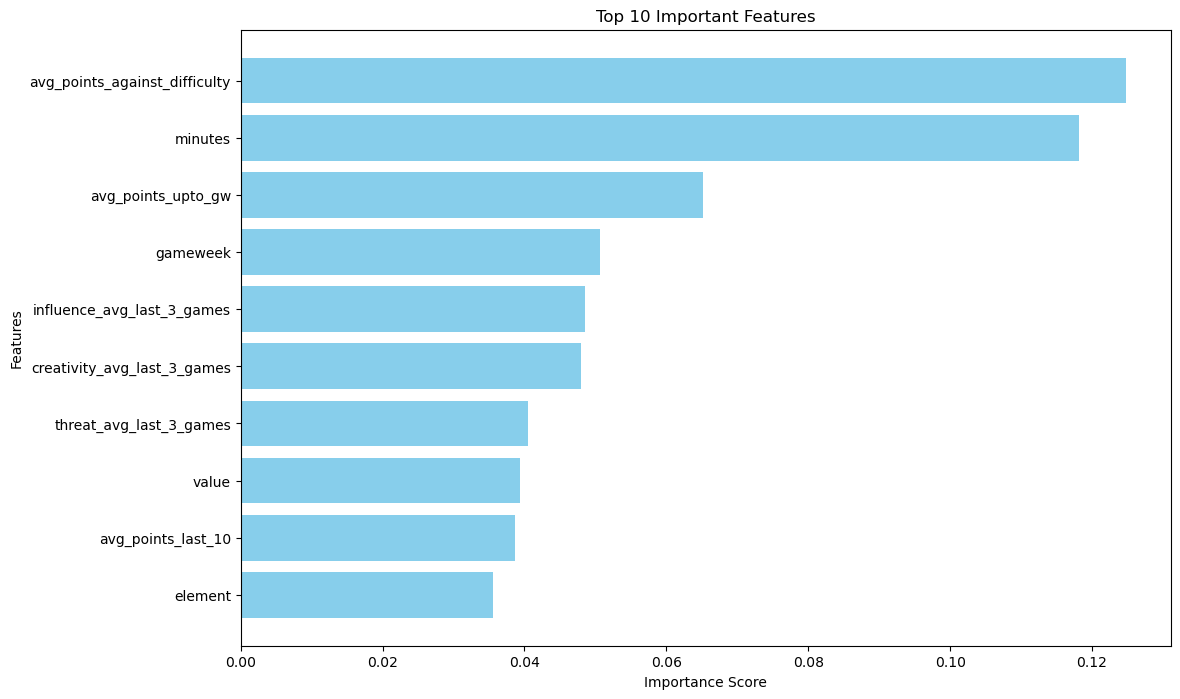

In [65]:
feature_importances = rf_regressor.feature_importances_
features = list(X_train.drop(columns=['name', 'kickoff_time']).columns)
feature_importance_map = dict(zip(features, feature_importances))
sorted_feature_importances = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)

#top features
top_features = sorted_feature_importances[:10]
feature_names = [feature[0] for feature in top_features]
importance_scores = [feature[1] for feature in top_features]


plt.figure(figsize=(12, 8))
plt.barh(feature_names, importance_scores, color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 10 Important Features')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Feature Selection: Drop features with very low importance
threshold = 0.001  # Arbitrary threshold for feature importance
important_features = [feature for feature, importance in feature_importance_map.items() if importance > threshold]
unimportant_features = [feature for feature, importance in feature_importance_map.items() if importance < threshold]

X_train_refined = X_train[important_features]
X_val_refined = X_val[important_features]

# Retrain the model
rf_regressor_refined = RandomForestRegressor(n_jobs=-1, random_state=42)
rf_regressor_refined.fit(X_train_refined, y_train)
y_val_pred_rf_refined = rf_regressor_refined.predict(X_val_refined)
rmse_val_rf_refined = mean_squared_error(y_val, y_val_pred_rf_refined, squared=False)

rmse_val_rf_refined

1.7197988671049484

In [ ]:
# Hyper parameter tuning on info
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the random forest regressor
rf = RandomForestRegressor(random_state=42)

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search model (this will take some time due to the numerous combinations)
grid_search.fit(X_train.drop(columns=['name', 'season', 'team', 'opponent_team_name']), y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_feat

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 4.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 4.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 5.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 4.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.5min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 4.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 5.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.5min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 8.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 8.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 8.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 8.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 8.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 8.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 4.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 5.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 5.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  57.8s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 3.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 3.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 7.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 3.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 7.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 7.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  56.7s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  57.1s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 5.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 3.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 5.5min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 5.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  53.1s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  57.6s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  54.2s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 2.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 3.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 4.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 4.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 5.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  54.3s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 2.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  53.6s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 2.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 4.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 4.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 5.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  55.5s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  56.7s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  54.5s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 4.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 3.0min
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 4.6min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.3s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 4.9min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  15.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  45.5s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 2.7min
[CV] END max_depth=None

/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  45.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  14.5s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 2.6min
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 2.8min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  15.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 4.6min
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 4.5min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  14.5s
[CV] END max_depth=Non

/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 1.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 1.3min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  42.1s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  41.8s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.2min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  45.7s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.3min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  39.9s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  40.4s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  39.8s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time= 1.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time= 1.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time= 1.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  41.8s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  41.6s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  40.5s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 2.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 2.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 2.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  40.1s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  39.4s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  38.5s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 1.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 2.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 2.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 3.3min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 3.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 3.5min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  39.9s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  40.3s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  38.7s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 3.3min
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 3.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 3.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 2.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 2.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 2.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  39.4s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  37.3s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  44.2s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 3.3min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 3.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 3.5min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  39.9s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  40.7s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  39.6s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 3.2min
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 3.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 3.5min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  41.3s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  41.8s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  39.0s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 2.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 2.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 2.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 3.3min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 3.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 3.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  44.1s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  40.4s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  43.3s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 2.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 2.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 2.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 3.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 3.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 3.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  41.8s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  39.4s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  43.6s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 3.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 3.5min
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.2min
[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 3.6min
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  12.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  11.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  33.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  32.8s
[CV] END max_depth=10, max_features=sqrt

/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=  38.7s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  57.1s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  33.3s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  54.3s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  32.8s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  33.5s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  55.3s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time=  57.5s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=  52.8s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=  56.0s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=  55.3s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  56.3s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  59.0s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 3.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 3.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 3.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  56.8s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  59.9s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  57.1s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 4.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 4.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 5.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  58.8s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  54.8s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 4.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 2.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 4.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 5.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 3.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  54.5s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  58.4s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 4.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 5.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 4.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 3.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  55.9s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  59.2s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  55.1s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 4.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 4.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 4.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  54.2s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  56.9s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=  54.4s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 2.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 3.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 4.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 4.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 4.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  57.2s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 3.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 4.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 3.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 4.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 5.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  56.6s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  55.2s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 4.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 3.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 3.1min
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 5.1min
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 5.0min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  19.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  21.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  21.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 1.0min
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 3.1min
[CV] END max_depth=20, max_features=sqr

/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 1.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 1.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  39.1s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  41.0s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=  41.3s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time= 1.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 3.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 3.3min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 3.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 3.3min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 3.3min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 3.5min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.3min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 5.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 6.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time= 6.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 3.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 5.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 3.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 5.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500; total time= 5.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 3.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  53.5s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  55.1s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  56.7s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 5.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.8min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 5.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 5.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  52.1s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  55.7s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  53.9s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 4.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 4.7min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time= 5.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 1.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 1.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 1.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 3.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 3.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time= 3.4min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 5.1min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 5.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500; total time= 5.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 3.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 5.3min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 3.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 3.2min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 5.3min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time= 5.6min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  52.6s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  57.2s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  53.9s


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 5.0min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 2.9min


/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 4.9min
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 3.2min
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time= 5.2min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.8s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  51.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  53.2s
[CV] END max_depth=30, max_features=auto

/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best Hyperparameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}


In [ ]:
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}


In [67]:
# Train the model using the best hyperparameters
best_params = {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
best_rf = RandomForestRegressor(**best_params, random_state=42)

X_train_test = pd.concat([X_train, X_val])
y_train_test = pd.concat([y_train, y_val])
best_rf.fit(X_train_test.drop(columns=['name', 'kickoff_time']), y_train_test)

# Predict on the test set
#y_val_pred_rf = rf_regressor.predict(X_val.drop(columns=['name', 'season', 'team', 'opponent_team_name']))
#rmse_val_rf = np.sqrt(mean_squared_error(y_val, y_val_pred_rf))

y_test_pred = best_rf.predict(X_test.drop(columns=['name', 'fixture', 'selected', 'kickoff_time']))

/home/dheyaydesai/anaconda3/envs/272class/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [72]:
X_test['xP'] = y_test_pred
X_test['actual_points'] = y_test

X_test[X_test['xP'] > 1]
#.where((X_test['team'] == 'Man City')).dropna()

,name,element,fixture,minutes,opponent_team,selected,value,was_home,gameweek,kickoff_time,...,opponent_team_villa,opponent_team_watford,opponent_team_west,opponent_team_wolves,season_2020-21,season_2021-22,season_2022-23,season_2023-24,xP,actual_points
2325,Aleksandar Mitrović,41,90,90,18,0,74,True,9.0,2023-10-23 19:00:00+00:00,...,0,0,0,0,0,0,0,1,1.741654,0
2448,Alex Iwobi,42,90,90,18,0,54,True,9.0,2023-10-23 19:00:00+00:00,...,0,0,0,0,0,0,0,1,2.390376,0
4406,Andreas Hoelgebaum Pereira,83,90,90,18,0,55,True,9.0,2023-10-23 19:00:00+00:00,...,0,0,0,0,0,0,0,1,1.793550,0
8074,Ben Davies,146,90,90,10,0,43,False,9.0,2023-10-23 19:00:00+00:00,...,0,0,0,0,0,0,0,1,1.120130,0
9577,Bernd Leno,170,90,90,18,0,47,True,9.0,2023-10-23 19:00:00+00:00,...,0,0,0,0,0,0,0,1,2.333370,0
10072,Bobby Decordova-Reid,177,90,90,18,0,55,True,9.0,2023-10-23 19:00:00+00:00,...,0,0,0,0,0,0,0,1,1.429380,0
10731,Brennan Johnson,189,90,90,10,0,58,False,9.0,2023-10-23 19:00:00+00:00,...,0,0,0,0,0,0,0,1,4.086051,0
12282,Carlos Vinicius Alves Morais,219,90,90,18,0,48,True,9.0,2023-10-23 19:00:00+00:00,...,0,0,0,0,0,0,0,1,1.232183,0
15653,Cristian Romero,278,90,90,10,0,48,False,9.0,2023-10-23 19:00:00+00:00,...,0,0,0,0,0,0,0,1,1.937592,0
18615,Davinson Sánchez,328,90,90,10,0,44,False,9.0,2023-10-23 19:00:00+00:00,...,0,0,0,0,0,0,0,1,1.138012,0


In [70]:
sorted(y_test_pred)[::-1]

[4.959423844666418,
 4.901563605442178,
 4.485213196748576,
 4.40414397887989,
 4.378400813482462,
 4.15778527592012,
 4.086050813145119,
 3.8157544103664556,
 3.575653304081021,
 3.0627345563078996,
 2.745893533363565,
 2.3903759234512862,
 2.3333704575972556,
 1.9375916527095032,
 1.7935503395084447,
 1.7416539649663318,
 1.7410691900654962,
 1.5165495795747403,
 1.4293798185733684,
 1.396785525102358,
 1.3359401711592207,
 1.2840914295287342,
 1.2321831403176295,
 1.14845901934323,
 1.1380115028246607,
 1.1201301180286576,
 0.9393899757729705,
 0.902114411027569,
 0.8919421888053468,
 0.854151065887059,
 0.8108758288807743,
 0.8104436323306712,
 0.7847887567904973,
 0.6782087681711331,
 0.6540763751329558,
 0.6070181893383605,
 0.5740014814838348,
 0.5566205838354982,
 0.5382913574476502,
 0.5126882097266607,
 0.4460394631729164,
 0.44524710790535527,
 0.42057232845810627,
 0.38879916784723706,
 0.28725115377855964,
 0.25487871156869046,
 0.08463333333333332,
 0.07364791666666666,
 

## XGBoost

In [23]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.api as sm

In [20]:
last_gameweek = player_df.where(player_df['season'] == '2023-24')['gameweek'].max()

train_data = player_df[~((player_df['season'] == '2023-24') & (player_df['gameweek'] == last_gameweek))]
test_data = player_df[(player_df['season'] == '2023-24') & (player_df['gameweek'] == last_gameweek)]

X_train, X_val, y_train, y_val = train_test_split(train_data.drop(columns=['total_points']), train_data['total_points'], test_size=0.3)

X_test = test_data.drop(columns=['total_points'])
y_test = test_data['total_points']

X_train.shape, X_val.shape, X_test.shape, last_gameweek

((56275, 92), (24118, 92), (800, 92), 7.0)

In [21]:
xgb_model = XGBRegressor(objective='reg:squarederror')
xgb_model.fit(X_train.drop(columns=['name', 'season', 'team', 'opponent_team_name']), y_train)

y_pred_train = xgb_model.predict(X_train.drop(columns=['name', 'season', 'team', 'opponent_team_name']))
y_pred_val = xgb_model.predict(X_val.drop(columns=['name', 'season', 'team', 'opponent_team_name']))
mae_val_rf = mean_absolute_error(y_val, y_pred_val)

print(y_train.shape, y_pred_train.shape)
print("Train RMSE: ", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("Val RMSE: ", np.sqrt(mean_squared_error(y_val, y_pred_val)))
print("Val MAE:", mae_val_rf)

(56275,) (56275,)
Train RMSE:  1.2380199522678033
Val RMSE:  1.7102864629829857
Val MAE: 0.7787802040822542


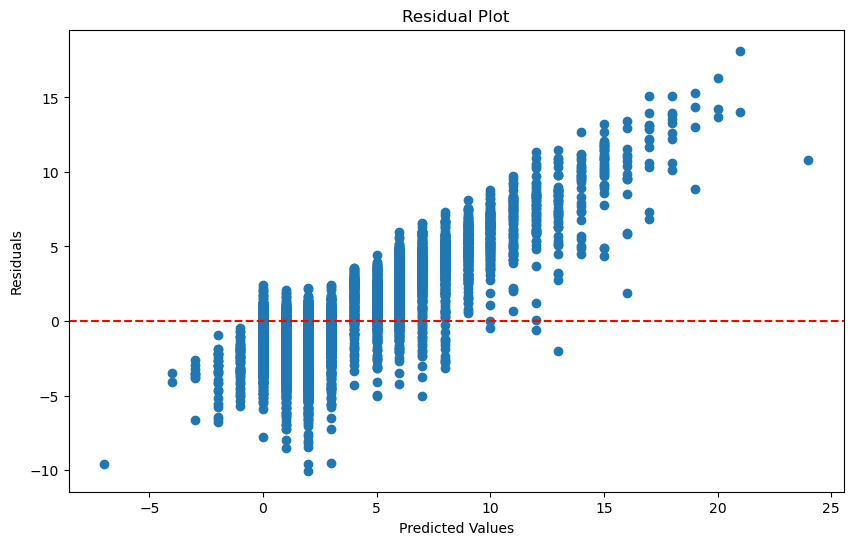

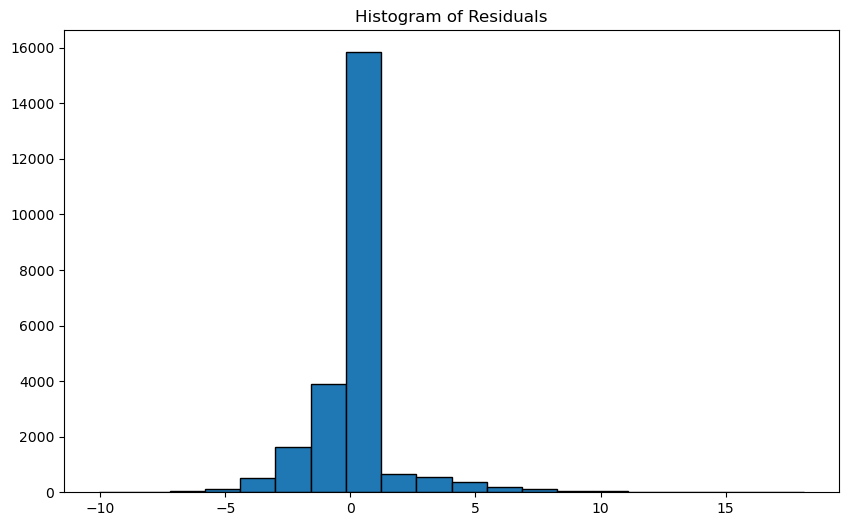

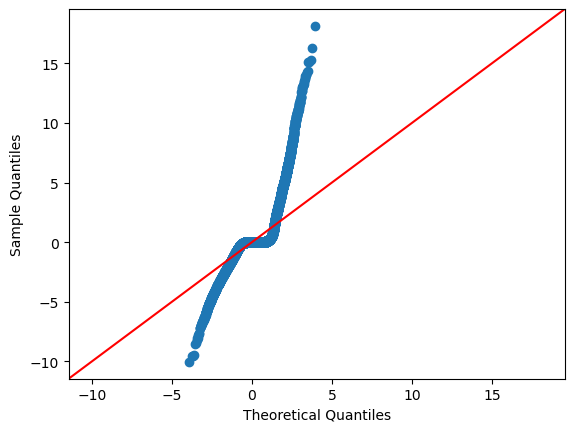

Durbin-Watson statistic: 2.01


In [24]:
residuals = y_val - y_pred_val

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_val, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Histogram of Residuals')
plt.show()

# QQ Plot
sm.qqplot(residuals, line ='45')
plt.show()

# Calculate Durbin-Watson statistic
durbin_watson = sm.stats.durbin_watson(residuals)
print(f'Durbin-Watson statistic: {durbin_watson:.2f}')

In [33]:
X_train_test = pd.concat([X_train, X_val])
y_train_test = pd.concat([y_train, y_val])

xgb_model_reg = XGBRegressor(objective='reg:squarederror', reg_alpha=0.1, reg_lambda=1)
xgb_model_reg.fit(X_train_test.drop(columns=['name', 'season', 'team', 'opponent_team_name']), y_train_test)

y_pred_test = xgb_model_reg.predict(X_test.drop(columns=['name', 'season', 'team', 'opponent_team_name']))
print(y_pred_test)

[ 2.7385561   5.12319     3.5569854   4.6317754   0.5958637   0.56000316
  3.6063695   4.2907233   2.518927    1.1279597   2.4061186   2.2074208
  3.097912    3.380297    1.9911108   2.793351    1.6398834   2.1635027
  2.159431    1.9782553   2.0863125   3.2266974   1.10085     2.8847506
  4.2630386   1.9193528   1.1350795   2.9607992   0.9744958   2.81492
  5.581058    4.590859    4.679063    2.910887    5.344315    2.7585034
  1.4024922   3.9035008   1.6766425   1.6756487   6.6099463   3.7289033
  3.5105214   2.4463727   3.2262523   2.350809    2.906239    1.930456
  5.7439475   0.36604056  3.3346007   2.2096353   0.6085778   4.792741
  0.2573813   3.9063237   1.2832115   7.500166    1.505796    1.982217
  0.81342864  3.9930005   0.8632469   1.6434369   3.5939598   4.6014276
  1.2008625   4.9274426   2.8798478   2.250912    4.768503    1.2505461
  1.9911108   2.8622816   1.5144619   1.5645292   4.0958657   5.0278854
  1.0162526   4.996176    0.49781737  3.0308492   4.82168     2.0919

In [34]:
X_test['xP'] = y_test_pred
X_test['actual_points'] = y_test

X_test[['name', 'element', 'team', 'season', 'xP']].where((X_test['team'] == 'Man Utd')).dropna()

,name,element,team,season,xP
607,Aaron Wan-Bissaka,401.0,Man Utd,2023-24,4.38
2185,Alejandro Garnacho,382.0,Man Utd,2023-24,3.22
2890,Alex Telles,370.0,Man Utd,2023-24,1.90
3890,Altay Bayindir,695.0,Man Utd,2023-24,2.61
3979,Amad Diallo,371.0,Man Utd,2023-24,2.36
4955,André Onana,597.0,Man Utd,2023-24,6.78
5841,Anthony Martial,390.0,Man Utd,2023-24,3.64
6065,Antony Matheus dos Santos,372.0,Man Utd,2023-24,3.34
10406,Brandon Williams,374.0,Man Utd,2023-24,3.17
10668,Bruno Borges Fernandes,373.0,Man Utd,2023-24,4.89


## LSTM

In [52]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np

# TODO Make sequences correctly based on past game data
def generate_train_sequences(data, sequence_length):
    from datetime import datetime
    # Filter data to keep only rows where the kickoff time is in the past
    current_time = datetime.utcnow()
    import pytz
    current_time = current_time.replace(tzinfo=pytz.UTC)
    train_data = data[data['kickoff_time'] <= current_time]

    X_train, y_train = [], []
    for name, player_data in train_data.groupby('element'):
        # Ensure data is in correct order by sorting based on kickoff_time
        player_data = player_data.sort_values(by='kickoff_time')
        for i in range(len(player_data) - sequence_length):
            X_train.append(player_data.iloc[i:i+sequence_length].drop(columns=['name', 'kickoff_time', 'total_points']).values)
            y_train.append(player_data.iloc[i+sequence_length]['total_points'])
    return np.array(X_train), np.array(y_train)

def generate_test_sequences(data, sequence_length):
    from datetime import datetime
    # Filter data to keep only rows where the kickoff time is in the future
    current_time = datetime.utcnow()
    import pytz
    current_time = current_time.replace(tzinfo=pytz.UTC)

    X_test = []
    for name, player_data in data.groupby('element'):
        # Ensure data is in correct order by sorting based on kickoff_time
        player_data = player_data.sort_values(by='kickoff_time')
        # Use the last `sequence_length` games for each player for test data
        processed_data = player_data.tail(sequence_length).drop(columns=['name', 'kickoff_time', 'total_points']).values
        if processed_data.shape != (sequence_length, 93):  # Assuming 92 is the expected number of features
            print(f'Inconsistent shape for element {name}: {processed_data.shape}')
            continue
        X_test.append(processed_data)
        
    X_test = np.stack(X_test)
    return np.array(X_test)


data = player_df
data = pd.get_dummies(data, columns=['season'])

sequence_length = 3
X_train, y_train = generate_train_sequences(data, sequence_length)
X_test = generate_test_sequences(data, sequence_length)

X_train.shape, y_train.shape, X_test.shape

Inconsistent shape for element 28: (2, 93)
Inconsistent shape for element 90: (2, 93)
Inconsistent shape for element 734: (2, 93)
Inconsistent shape for element 785: (2, 93)
Inconsistent shape for element 861: (2, 93)
Inconsistent shape for element 877: (2, 93)
Inconsistent shape for element 923: (1, 93)
Inconsistent shape for element 1003: (1, 93)
Inconsistent shape for element 1129: (1, 93)
Inconsistent shape for element 1343: (2, 93)
Inconsistent shape for element 1367: (1, 93)
Inconsistent shape for element 1375: (2, 93)
Inconsistent shape for element 1402: (1, 93)
Inconsistent shape for element 1468: (1, 93)


((78133, 3, 93), (78133,), (1474, 3, 93))

In [54]:
## TODO: Player elements are not unique for every player, assign a unique elment id to each player with the same name, check normalize
##              player ids function again.
## Try sample here
group_element = player_df.groupby('element')
print(group_element.get_group(3))

def map_id_name(player_df):
    names = player_df['name'].unique()
    id_map = {name: idx for idx, name in enumerate(names)}
    player_df['element'] = player_df['name'].map(id_map)
    return player_df

copy_df = player_df.copy()
copy_df = map_id_name(copy_df)
copy_df = pd.get_dummies(copy_df, columns=['season'])

group_element = copy_df.groupby('element')
print(group_element.get_group(3))


len(player_df['name'].unique()), len(player_df['element'].unique()), len(copy_df['name'].unique()), len(copy_df['element'].unique())

                   name  element  fixture  minutes  opponent_team  selected  \
31956  Jack Hinshelwood        3      172        0              1         0   
31957  Jack Hinshelwood        3      186        0              8        17   
31958  Jack Hinshelwood        3      193        0             12        57   
31959  Jack Hinshelwood        3      206        0             10        70   
31960  Jack Hinshelwood        3      213        0              3       104   
31961  Jack Hinshelwood        3      223        0              7       133   
31962  Jack Hinshelwood        3      233        0              9       142   
31963  Jack Hinshelwood        3      254        0             19       165   
31964  Jack Hinshelwood        3      265        0             11       181   
31965  Jack Hinshelwood        3       73        0              7       181   
31966  Jack Hinshelwood        3      283        0              4       193   
31967  Jack Hinshelwood        3       62        0  

(1488, 1488, 1488, 1488)

In [55]:
X_t, y_t = generate_train_sequences(copy_df, sequence_length=sequence_length)
X_test  = generate_test_sequences(copy_df, sequence_length=sequence_length)

X_t = X_t.astype('float32')
y_t = y_t.astype('float32')

Inconsistent shape for element 231: (1, 93)
Inconsistent shape for element 361: (2, 93)
Inconsistent shape for element 511: (2, 93)
Inconsistent shape for element 589: (2, 93)
Inconsistent shape for element 662: (2, 93)
Inconsistent shape for element 779: (2, 93)
Inconsistent shape for element 1001: (2, 93)
Inconsistent shape for element 1098: (1, 93)
Inconsistent shape for element 1274: (1, 93)
Inconsistent shape for element 1295: (2, 93)
Inconsistent shape for element 1340: (1, 93)
Inconsistent shape for element 1388: (2, 93)
Inconsistent shape for element 1449: (1, 93)
Inconsistent shape for element 1464: (1, 93)


In [56]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(100, return_sequences=True, activation='tanh', input_shape=(X_t.shape[1], X_t.shape[2])),
    BatchNormalization(),
    LSTM(50, return_sequences=True, activation='tanh'),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(25, activation='tanh'),
    BatchNormalization(),
    Dense(1)
])

# Consider gradient clipping to avoid exploding gradients
opt = Adam(clipnorm=1.0)

model.compile(optimizer=opt, loss='mse', metrics=['mae'])

# Define an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

2023-10-22 17:06:17.469795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-22 17:06:17.471546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-22 17:06:17.472955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [57]:
history = model.fit(X_t, y_t, epochs=150, batch_size=16, validation_split=0.3, callbacks=[early_stopping])

Epoch 1/150


2023-10-22 17:06:18.169524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-22 17:06:18.170733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-22 17:06:18.172071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3413/3419 [============================>.] - ETA: 0s - loss: 6.1968 - mae: 1.4876

2023-10-22 17:06:44.907782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-22 17:06:44.909088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-22 17:06:44.910075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3419/3419 [==============================] - 30s 8ms/step - loss: 6.1943 - mae: 1.4874 - val_loss: 7.9823 - val_mae: 1.5715
Epoch 2/150
3419/3419 [==============================] - 25s 7ms/step - loss: 5.9432 - mae: 1.4952 - val_loss: 8.3069 - val_mae: 1.6573
Epoch 3/150
3419/3419 [==============================] - 24s 7ms/step - loss: 5.9580 - mae: 1.5051 - val_loss: 5.4803 - val_mae: 1.3878
Epoch 4/150
3419/3419 [==============================] - 26s 8ms/step - loss: 5.9711 - mae: 1.5088 - val_loss: 13.3838 - val_mae: 2.7333
Epoch 5/150
3419/3419 [==============================] - 26s 8ms/step - loss: 5.9711 - mae: 1.5294 - val_loss: 16.4099 - val_mae: 3.8559
Epoch 6/150
3419/3419 [==============================] - 26s 8ms/step - loss: 5.9632 - mae: 1.5248 - val_loss: 8.5051 - val_mae: 1.6485
Epoch 7/150
3419/3419 [==============================] - 26s 8ms/step - loss: 5.9227 - mae: 1.5164 - val_loss: 11.3721 - val_mae: 2.4160
Epoch 8/150
3419/3419 [==============================] - 

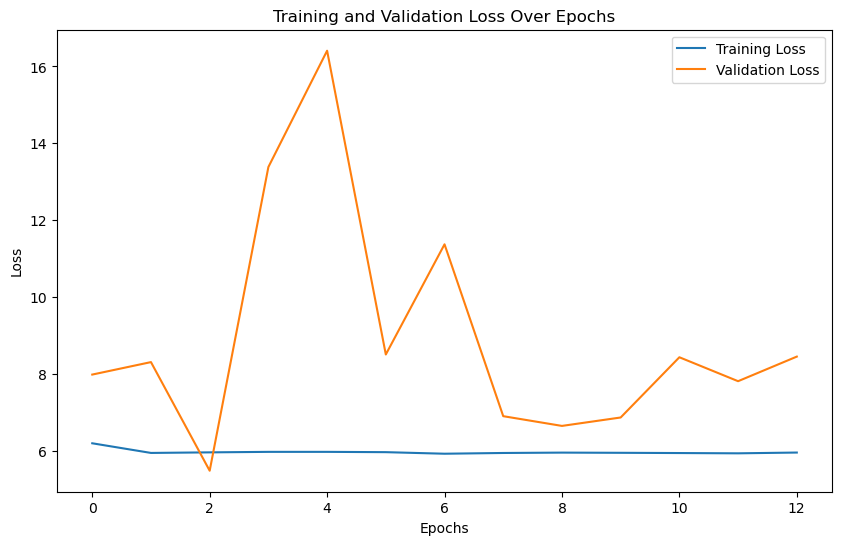

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [59]:
# Check predictions on X_test
X_test = X_test.astype('float32')
predictions = model.predict(X_test)
predictions = predictions.flatten()

predictions

2023-10-22 17:11:59.311196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-22 17:11:59.312243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-22 17:11:59.313206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

47/47 [==============================] - 1s 3ms/step


array([1.0847172, 1.0915483, 1.0948176, ..., 0.5175554, 1.1084932,
       1.1084932], dtype=float32)

In [61]:
'''
Notes on LSTM application for current data:

Results not upto mark
Sequencing has missing data (filling is an issue, skews player performance)
Underfitting
Somewhat constant loss for both validation and training ~ no changes despite architecture difference in LSTMs
Potentially because of less feature information (Consider more features for LSTM's?)
'''

sorted(predictions)[::-1]

[1.2034276,
 1.1976424,
 1.1966481,
 1.1935992,
 1.184957,
 1.1403159,
 1.1283352,
 1.1276214,
 1.127204,
 1.1233374,
 1.1227087,
 1.1219356,
 1.1208379,
 1.1195848,
 1.1195529,
 1.1183602,
 1.1181192,
 1.117188,
 1.1170363,
 1.1170281,
 1.1170005,
 1.1168523,
 1.1165372,
 1.1164076,
 1.1159651,
 1.1143754,
 1.1141183,
 1.1138251,
 1.1134682,
 1.1126595,
 1.112627,
 1.1124861,
 1.112127,
 1.111784,
 1.1116422,
 1.1112607,
 1.1112437,
 1.1107657,
 1.1107248,
 1.1103015,
 1.110065,
 1.1098986,
 1.1093653,
 1.1090851,
 1.1090084,
 1.1089041,
 1.108856,
 1.108845,
 1.1088345,
 1.1087421,
 1.1086893,
 1.1086345,
 1.1085994,
 1.1085856,
 1.1085184,
 1.1085162,
 1.1085026,
 1.1085011,
 1.1084977,
 1.1084973,
 1.1084945,
 1.1084936,
 1.1084936,
 1.1084932,
 1.1084932,
 1.1084932,
 1.1084932,
 1.1084932,
 1.1084932,
 1.1084932,
 1.1084932,
 1.1084932,
 1.1084932,
 1.1084932,
 1.1084932,
 1.1084932,
 1.1084932,
 1.1084932,
 1.1084932,
 1.1084932,
 1.1084932,
 1.1084932,
 1.1084932,
 1.1084932,
 